In [1]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [2]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [3]:
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

In [109]:
"""
Grid search for best pdq value based on aic 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs_aic(df, seasonal=12, display=True):   

    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))
    
    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            try:
                results = train_sarimax(df, pdq=combo, PDQS=combo_seasonal, summary=False)
                # TODO - test for RMSE and append 
                output.append([combo, combo_seasonal, results.aic])
                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, AIC: {output.aic}')
            except:
                continue
            
    # Find the parameters with minimal AIC value
    output_df = pd.DataFrame(output, columns=['pdq', 'pdqs', 'aic'])
    pdq = tuple(output_df[output_df.aic == output_df.aic.min()]['pdq'].values[0])
    PDQS = tuple(output_df[output_df.aic == output_df.aic.min()]['pdqs'].values[0])

    return output_df, pdq, PDQS 

In [122]:
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), summary=False, diagnostics=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=True, 
                                          enforce_invertibility=True)
    
    results = arima_mod.fit()
    
    if summary:
        print(results.summary())
    
    if diagnostics:
        results.plot_diagnostics(figsize=(14,10))
    
    return results 

In [6]:
""" 
takes in string and splits data
date entered is included in the train data 
"""
def split_train_test(df, split='2015-03-01'):
    return df.loc[:split], df.loc[pd.to_datetime(split) + pd.DateOffset(months=1):]

In [124]:
def train_results_rmse(results, train, period=24, display=True):
    # predict going back from 2 years, or other time specified 
    train_predict = results.predict(-period)
    
    # visualize results, plot train vs. predicted values 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        train.plot(ax=ax, label='train actual')
        # plot one step ahead predictions 
        train_predict.plot(ax=ax, style='r--', label='one step ahead forecast')
        legend=ax.legend(loc='lower right')

    rmse = np.sqrt(mean_squared_error(train_predict, train[-period:])) 
    print(f'\nTraining RMSE: {rmse}')
    return rmse 

In [8]:
# walk forward validation on test data 
# return RMSE 
def test_results_rmse(results, train, test, pdq=(1,1,1), PDQS=(1,1,1,12), display=True):
    # walk-forward validation
    predictions=[]
    history = [x for x in train.values]
    actuals = test.values

    for t in range(len(test)):
        results = train_sarimax(history, pdq=pdq, PDQS=PDQS, summary=False)
        output=results.forecast()
        y_hat = output[0]
        predictions.append(y_hat)
        actual = actuals[t]
        history.append(actual)
        #print('predicted: {}, expected: {}'.format(y_hat, actual))
    
    # convert predictions from list to series so rmse can be calculated 
    predictions = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f'Test RMSE: {rmse}')
    
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='predictions')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    return rmse 

In [9]:
# dynamic predictions on test data using results 
# return RMSE 
def test_dynamic_predictions(results, test, display=True):
    # dynamic prediction 
    dynamic_pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
    predictions = dynamic_pred.predicted_mean
    actuals = test.values 
    pred_ci = dynamic_pred.conf_int()
    
    # visualize test vs. dynamic predictions 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
    #     plt.plot(train['2014-01-01':], label='training')
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='dynamic forecast')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('Test Dynamic Forecast vs. Test Actuals')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    # get the rmse and return 
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f'RMSE: {rmse}')
    
    return rmse 

In [130]:
def forecast_results(df, results, pdq=(1,1,1), PDQS=(1,1,1,12), years=[1,3,5,10]):
    # retrain new model on all data
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS)
    
    # get the last date in the data
    start_date = df.index[-1]

    for yr in [1,3,5,10]:
        # get the actual current price  
        current_actual = df.loc[start_date].values[0] 
        
        # add yr to the current date 
        end_date = start_date + pd.DateOffset(years=yr)
        
        # get dynamic predictions, values and the final prediction at the end of the series 
        dynamic_pred = results.get_prediction(start=start_date, end=end_date)
        predictions = dynamic_pred.predicted_mean 
        final_prediction = predictions[-1]
        
        # get confidence interval 
        pred_ci = dynamic_pred.conf_int()

        # get the ROI multiple 
        roi = (final_prediction - current_actual)/current_actual 

        print(f'Current price: ${current_actual}, Price after {yr} year(s): ${final_prediction.round(2)}')
        print(f'ROI for {yr} year(s):{roi}\n')

    # plot 10 years of predictions 
    fig,ax=plt.subplots(figsize=(12,5))
    predictions.plot(ax=ax, label='test actuals')
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
    plt.title('10 Year Forecast')
    legend=ax.legend(loc='lower right')
    plt.show()

In [18]:
def get_nj(df):
    
    nj = df[df.State == 'NJ']
    missing = nj.isna().sum().values.sum() 
    
    if missing > 0:
        print('{missing} missing values.')
        return False 
    else: 
        print('{} unique zip codes in NJ'.format(nj.RegionName.nunique()))
        return nj 

In [19]:
def melt_df(df):
    melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     print(f'{len(melted)} zip codes')
    
    if melted.isna().sum().values.sum() > 0:
        print('missing values present.')
    
    df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'price'}).set_index('time')
    
    return df 

In [27]:
data = pd.read_csv('zillow_data.csv')
sns.set_style('darkgrid')


In [28]:
nj = get_nj(data)
df = melt_df(nj)
df.head()

502 unique zip codes in NJ


,zip,price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


## Overall NJ Analysis 

In [29]:
nj_avg = df[['price']].groupby('time').price.median().reset_index().set_index('time')
nj_avg = nj_avg.asfreq('MS')
nj_avg

,price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


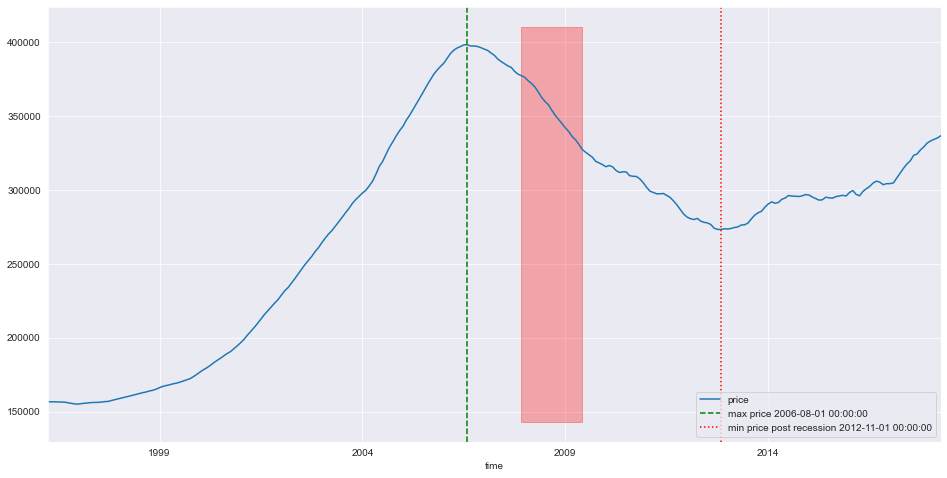

In [74]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Recession = December 2007 – June 2009
# TODO Fix 
fig,ax = plt.subplots(figsize=(16,8))
nj_avg.plot(ax=ax, label='median house prices')
recession = nj_avg.loc['2007-12-01':'2009-06-01']
min_recession = nj_avg.loc['2008':'2014'].price.idxmin()
max_overall = nj_avg.price.idxmax()

ax.fill_between(recession.index, ax.get_ylim()[0], ax.get_ylim()[1], color='red', alpha=0.3)
# plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
ax.axvline(max_overall, ls='--', color = 'g', label=f'max price {max_overall}')
ax.axvline(min_recession, ls=':', color = 'r', label=f'min price post recession {min_recession}')

legend=ax.legend(loc='lower right')

# years = np.arange(1996,2019,1)
# print(ax.get_xticklabels())
# print(years)
plt.show()

In [75]:
# not full years in 96 and 2018 
# year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
# temp_annual = pd.DataFrame()
# for yr, group in year_groups:
#     temp_annual[yr.year] = group.values.ravel()
# temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
# plt.show()

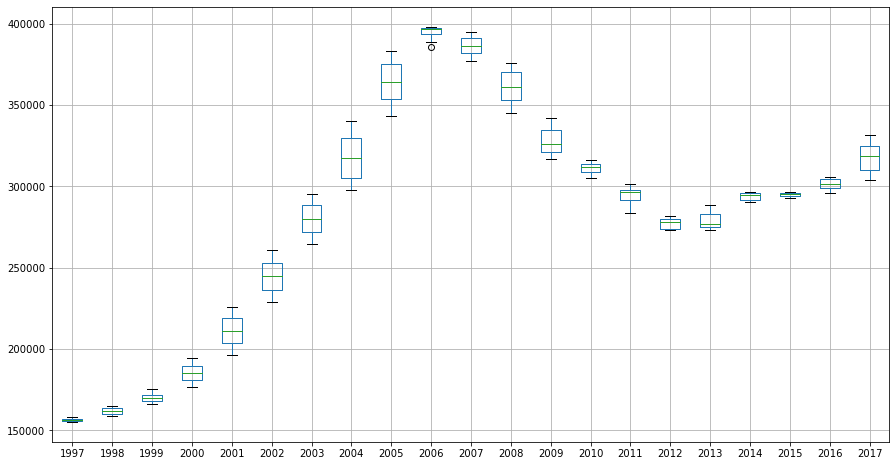

In [30]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [113]:
nj_avg_m = nj_avg.resample('MS').sum()
nj_avg_m = nj_avg_m['2012':]

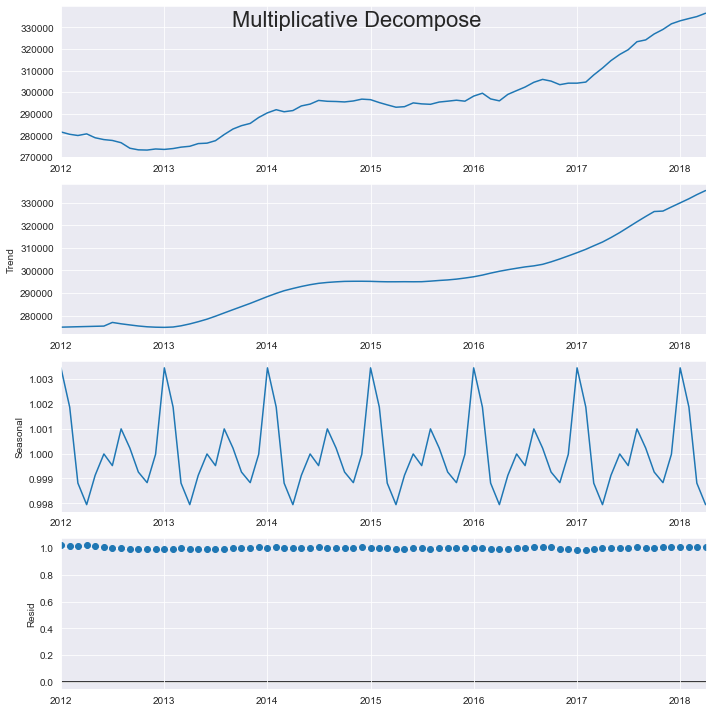

In [114]:
result_add = seasonal_decompose(nj_avg_m, model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()

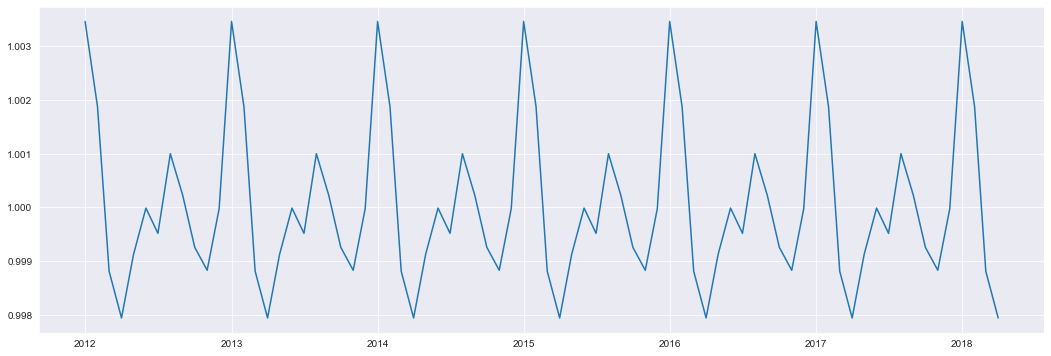

In [115]:
plt.figure(figsize=(18,6))
# TODO add dotted lines 
plt.plot(result_add.seasonal)
plt.show()

In [116]:
# get PDQS
output_df, pdq, PDQS = get_pdqs_aic(nj_avg_m) # TODO - make this output pdq, and PDQ so it can be added to next method 
output_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",2132.945456
1,"(0, 0, 0)","(0, 0, 1, 12)",2099.958326
2,"(0, 0, 0)","(0, 1, 0, 12)",1398.542438
3,"(0, 0, 0)","(0, 1, 1, 12)",1405.743587
4,"(0, 0, 0)","(1, 0, 0, 12)",1737.073040
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",1145.008657
60,"(1, 1, 1)","(1, 0, 0, 12)",1341.653375
61,"(1, 1, 1)","(1, 0, 1, 12)",1339.812850
62,"(1, 1, 1)","(1, 1, 0, 12)",1144.967237


In [117]:
# split into training and test data 
train, test = split_train_test(nj_avg_m)

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   39
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -232.414
Date:                            Sun, 06 Mar 2022   AIC                            474.828
Time:                                    16:47:17   BIC                            481.118
Sample:                                01-01-2012   HQIC                           476.639
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8870      0.070     12.734      0.000       0.750       1.024
ma.L1         -0.9043      0.066   

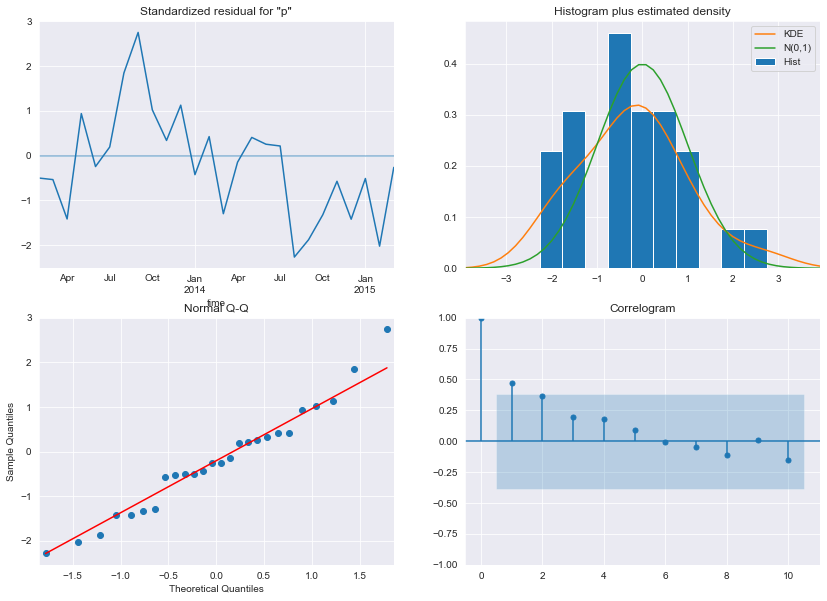

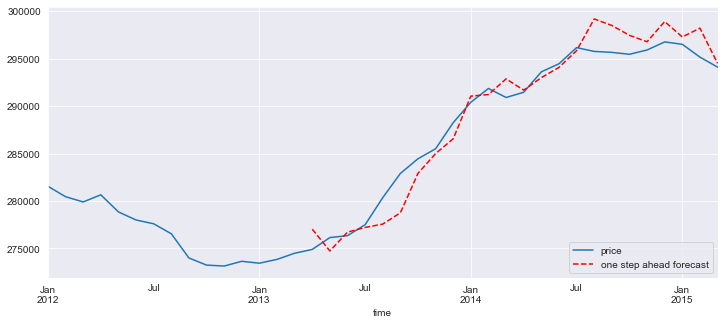

In [123]:
results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=True, diagnostics=True)
print('\n')
rmse = train_results_rmse(results, train, display=True)

Test RMSE: 2017.4224986347815


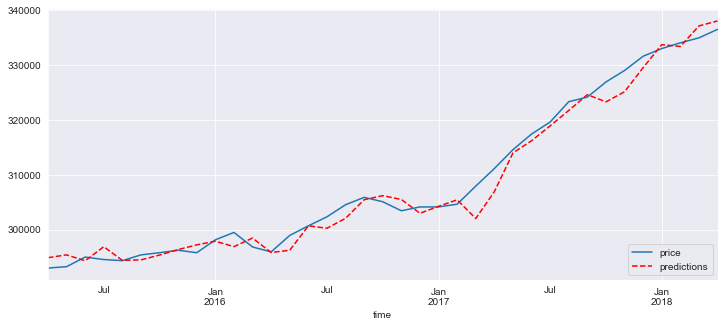

2017.4224986347815

In [126]:
test_results_rmse(results, train, test, pdq=pdq, PDQS=PDQS)

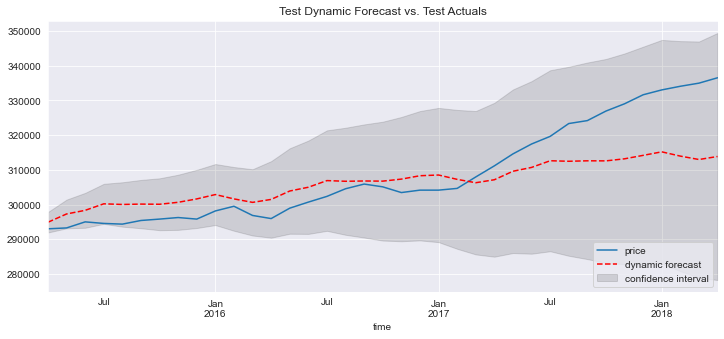

RMSE: 9400.345050242297


9400.345050242297

In [127]:
# dynamic prediction 
test_dynamic_predictions(results, test)

Current price: $336550.0, Price after 1 year(s): $359324.4
ROI for 1 year(s):0.06767017647029124

Current price: $336550.0, Price after 3 year(s): $406695.13
ROI for 3 year(s):0.20842408510650307

Current price: $336550.0, Price after 5 year(s): $454015.82
ROI for 5 year(s):0.34902932704036477

Current price: $336550.0, Price after 10 year(s): $573038.86
ROI for 10 year(s):0.7026856511226903



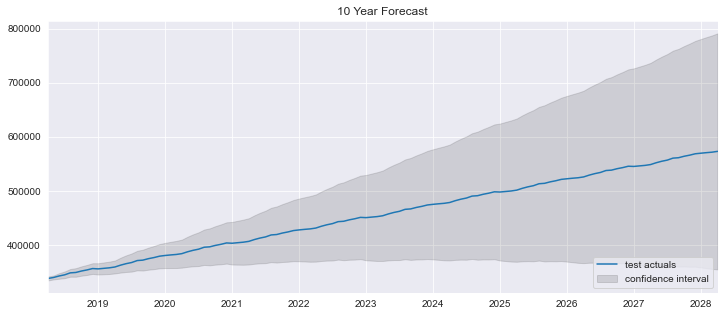

In [131]:
forecast_results(nj_avg_m, results)

In [59]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/


In [90]:
# TODO make predictions using differenced data vs non differenced data 